In [1]:
! pip install pytorch-metric-learning
! pip install MulticoreTSNE

In [2]:
import timm
import torch
from torch import optim
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torch import optim
import os

import matplotlib.pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
from pytorch_metric_learning.miners import TripletMarginMiner
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.losses import TripletMarginLoss
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning import losses, testers

from PIL import Image
import argparse

In [21]:
def args():
    def str2bool(v):
        if v.lower() in ('yes', 'true', 't', 'y', '1'):
            return True
        elif v.lower() in ('no', 'false', 'f', 'n', '0'):
            return False
        else:
            raise argparse.ArgumentTypeError('Unsupported value encountered.')
    
    #
    parser.add_argument('--data_path', default='./dataset/', type=str, dest='data_path')
    parser.add_argument('--exp', default=0, type=int, dest='exp')
    parser.add_argument('--seed', default=42, type=int, dest='seed')
    parser.add_argument('--debug', default=False, type=bool, dest='debug')
    
    parser.add_argument('--model_name', default='resnet34d', type=str, dest='model_name')
    parser.add_argument('--loss_name', default="TripletMargin", type=str, dest='loss_name')

    parser.add_argument('--epoch', default=20, type=int, dest='epoch')
    parser.add_argument('--pretrained', default=True, type=bool, dest='pretrained')
    parser.add_argument('--inp_channels', default=3, type=int, dest='inp_channels')
    parser.add_argument('--batch_size', default=64, type=int, dest='batch_size')
    parser.add_argument('--lr', default=1e-5, type=float, dest='lr')
    parser.add_argument('--out_features', default=128, type=int, dest='out_features')
    
    
    # python
    #args = parser.parse_args()

    # jupyter
    args_parser = parser.parse_args(args=['--exp', '3',
                                         '--loss_name', 'CosFace',
                                         '--inp_channels', '1'])
    return args_parser

In [22]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [23]:
def dataset():
    transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    train_dataset = datasets.FashionMNIST(CFG.data_path, train=True, download=False, transform=transform)
    test_dataset = datasets.FashionMNIST(CFG.data_path, train=False, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False)
    
    return train_loader, test_loader

In [24]:
class CustomModel(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.backbone = timm.create_model(
            model_name=CFG.model_name, pretrained=CFG.pretrained, num_classes=CFG.out_features, in_chans=CFG.inp_channels)
      
    def forward(self, x):
        x = self.backbone(x)
        output = x
        return output

In [25]:
def train(model, loss_func, mining_func, device, dataloader, optimizer, epoch):
    model.train() 
    for idx, (inputs, labels) in enumerate(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        if mining_func == None:
            embeddings = model(inputs)
            loss = loss_func(embeddings, labels)
        else:
            embeddings = model(inputs)
            indices_tuple = mining_func(embeddings, labels)
            loss = loss_func(embeddings, labels, indices_tuple)

        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print('Epoch {} Iteration {}: Loss = {}'.format(epoch, idx, loss))

In [26]:
def test(model, dataloader, device, epoch):
    _predicted_metrics = []
    _true_labels = []
    with torch.no_grad():    
        for i, (inputs,  labels) in enumerate(dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            metric = model(inputs).detach().cpu().numpy()
            metric = metric.reshape(metric.shape[0], metric.shape[1])
            _predicted_metrics.append(metric)
            _true_labels.append(labels.detach().cpu().numpy())
    return np.concatenate(_predicted_metrics), np.concatenate(_true_labels)

In [27]:
def tsne(epoch):
    inf_model = CustomModel(CFG).to(CFG.device)
    inf_model.load_state_dict(torch.load(OUTPUT_DIR + "/" + f'epoch{epoch}_model.pth'))
    test_predicted_metrics, test_true_labels = test(inf_model, test_loader, CFG.device, epoch)
    tSNE_metrics = TSNE(n_components=2, random_state=CFG.seed,n_jobs=4).fit_transform(test_predicted_metrics)

    plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=test_true_labels)
    plt.colorbar()
    plt.xlim([-40,40])
    plt.ylim([-40,40])
    plt.title(f"epoch{epoch}")
    plt.savefig(OUTPUT_DIR + "/" + f"output_epoch{epoch}.jpg")
    plt.show()

In [28]:
def create_gif():
    pictures=[]
    for i in range(1,CFG.epoch+1):
        pic_name=OUTPUT_DIR + f"output_epoch{i}.jpg"
        img = Image.open(pic_name)
        pictures.append(img)
    
    pictures[0].save(OUTPUT_DIR + "/" + 'anime.gif',save_all=True, append_images=pictures[1:],
    optimize=False, duration=500, loop=0)

False
Epoch 1/20
----------
Epoch 1 Iteration 0: Loss = 30.90568733215332
Epoch 1 Iteration 100: Loss = 28.49656105041504
Epoch 1 Iteration 200: Loss = 27.941028594970703
Epoch 1 Iteration 300: Loss = 25.93498992919922
Epoch 1 Iteration 400: Loss = 24.542537689208984
Epoch 1 Iteration 500: Loss = 21.464445114135742
Epoch 1 Iteration 600: Loss = 22.152292251586914
Epoch 1 Iteration 700: Loss = 20.04153060913086
Epoch 1 Iteration 800: Loss = 19.789630889892578
Epoch 1 Iteration 900: Loss = 19.21622085571289


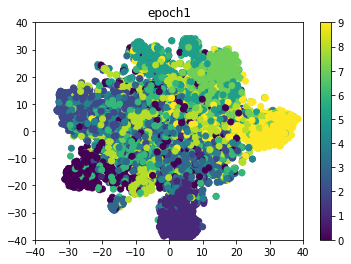

Epoch 2/20
----------
Epoch 2 Iteration 0: Loss = 14.431907653808594
Epoch 2 Iteration 100: Loss = 19.275135040283203
Epoch 2 Iteration 200: Loss = 15.996419906616211
Epoch 2 Iteration 300: Loss = 17.593055725097656
Epoch 2 Iteration 400: Loss = 14.47627067565918
Epoch 2 Iteration 500: Loss = 14.562217712402344
Epoch 2 Iteration 600: Loss = 14.059969902038574
Epoch 2 Iteration 700: Loss = 13.51162052154541
Epoch 2 Iteration 800: Loss = 12.145953178405762
Epoch 2 Iteration 900: Loss = 8.943700790405273


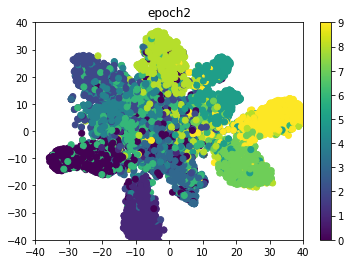

Epoch 3/20
----------
Epoch 3 Iteration 0: Loss = 8.745079040527344
Epoch 3 Iteration 100: Loss = 10.53763484954834
Epoch 3 Iteration 200: Loss = 10.980306625366211
Epoch 3 Iteration 300: Loss = 12.569581031799316
Epoch 3 Iteration 400: Loss = 11.443857192993164
Epoch 3 Iteration 500: Loss = 10.066902160644531
Epoch 3 Iteration 600: Loss = 12.459697723388672
Epoch 3 Iteration 700: Loss = 8.748429298400879
Epoch 3 Iteration 800: Loss = 11.636458396911621
Epoch 3 Iteration 900: Loss = 12.137971878051758


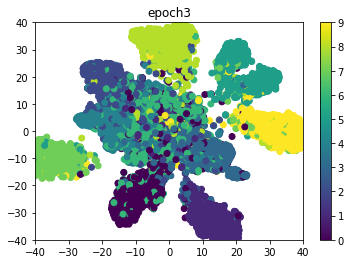

Epoch 4/20
----------
Epoch 4 Iteration 0: Loss = 8.6371488571167
Epoch 4 Iteration 100: Loss = 11.140863418579102
Epoch 4 Iteration 200: Loss = 7.066217422485352
Epoch 4 Iteration 300: Loss = 6.564399719238281
Epoch 4 Iteration 400: Loss = 10.459442138671875


In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    CFG = args()
    
    CFG.device = "cuda" if torch.cuda.is_available() else "cpu"
    
    print(CFG.debug)
    if CFG.debug:
        CFG.epoch = 1
    seed_everything(seed=CFG.seed)
    
    OUTPUT_DIR = './'+'ex'+str(CFG.exp)+'/'
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        
    train_loader, test_loader = dataset()
    
    
    model = CustomModel(CFG).to(CFG.device)
    optimizer = optim.Adam(model.parameters(), lr=CFG.lr)
    
    test_predicted_metrics = []
    test_true_labels = []
    model_loss = 0
    best_model_loss = 100

    if CFG.loss_name == 'TripletMargin':
        distance = CosineSimilarity()
        reducer = ThresholdReducer(low = 0)
        loss_func = TripletMarginLoss(margin=0.2, distance=distance, reducer=reducer)
        mining_func = TripletMarginMiner(margin=0.2, distance=distance)
        
    elif CFG.loss_name == 'SubCenterArcFace':
        loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(CFG.device)
    elif CFG.loss_name == 'CosFace':
        loss_func = losses.CosFaceLoss(num_classes=10, embedding_size=128).to(CFG.device)
    
    for epoch in range(1, CFG.epoch + 1):
        print('Epoch {}/{}'.format(epoch, CFG.epoch))
        print('-' * 10)
        if CFG.loss_name == 'TripletMargin': 
            train(model, loss_func, mining_func, CFG.device, train_loader, optimizer, epoch)
        else:
            mining_func = None
            train(model, loss_func, mining_func, CFG.device, train_loader, optimizer, epoch)
            
        torch.save(model.state_dict(),OUTPUT_DIR + "/" + f'epoch{epoch}_model.pth')
        tsne(epoch)
    
    #create gif 
    create_gif()

In [ ]:
# tSNE_metrics = TSNE(n_components=2, random_state=0).fit_transform(test_predicted_metrics)

# plt.scatter(tSNE_metrics[:, 0], tSNE_metrics[:, 1], c=test_true_labels)
# plt.colorbar()
# plt.savefig("output.png")
# plt.show()